In [632]:
import numpy as np
import scipy.stats, scipy.io,scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import pickle
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

In [863]:
def PF_gumbel(x,alpha,beta):
    return 1 - np.exp(-10**(beta*(x-alpha)))

def PF(x,alpha,beta,gamma,lam,PF=PF_gumbel,inverse=False):
    p = gamma + (1-gamma-lam) * PF(x,alpha,beta)
    
    if inverse:
        c = (x-gamma)/(1 - gamma - lam) - 1
        c = -1*np.log(-1*c)
        c = np.log10(c)
        p = alpha + c/beta   
    else:
        pass
    
    return p

def pdfNormal(x,Mean,SD):
    y = np.exp(-1*(x-Mean)**2/(2*SD**2))/((2*np.pi)**.5*SD)
    return y

def create_LUT(stim_range,ApriorRange,BpriorRange,Gprior,Lprior,grain):
    
    a = np.tile(ApriorRange,(grain,1)).T
    b = 10**np.tile(BpriorRange,(grain,1))
    x = np.tile(stim_range,(grain,grain,1)).T
    
    return PF(x,a,b,Gprior,Lprior)

def create_priorPDF(ApriorRange,BpriorRange,Aprior,Bprior,sigma,grain):
    a = np.tile(ApriorRange,(grain,1)).T
    b = np.tile(BpriorRange,(grain,1))
    
    return pdfNormal(a,Aprior,sigma) * pdfNormal(b,Bprior,sigma)

def calculate_entropy(pdf):
    entropy = pdf * np.log(pdf)
    entropy[np.isnan(entropy)] = 0
#     print(entropy)
    return -entropy.sum(axis=(1,2))

def UpdatePosteriorTplus1(PsiObject):
    pdfMatch = np.tile(PsiObject.prior_pdf,(PsiObject.stimRange.shape[0],1,1))
    pSuccessGivenx = (pdfMatch * PsiObject.LUT).sum(axis=(1,2))
    PosteriorTplus1givenSuccess = pdfMatch * PsiObject.LUT 
    PosteriorTplus1givenFailure = pdfMatch - PosteriorTplus1givenSuccess
    PosteriorTplus1givenSuccess = PosteriorTplus1givenSuccess / np.tile(PosteriorTplus1givenSuccess.sum(axis=(1,2)),(PsiObject.steps,PsiObject.steps,1)).T
    PosteriorTplus1givenFailure = PosteriorTplus1givenFailure / np.tile(PosteriorTplus1givenFailure.sum(axis=(1,2)),(PsiObject.steps,PsiObject.steps,1)).T
    
    return PosteriorTplus1givenSuccess,PosteriorTplus1givenFailure,pSuccessGivenx

def UpdatePSIObject(PSIOject,responses):
    trial = len(PSIOject.x)

    PSIOject.response.append(responses)
    
    if responses == 1:
        PSIOject.prior_pdf = PSIOject.posteriorTplus1givenSuccess[np.where(PSIOject.stimRange==PSIOject.xNow)[0]]
    else:
        PSIOject.prior_pdf = PSIOject.posteriorTplus1givenFailure[np.where(PSIOject.stimRange==PSIOject.xNow)[0]]
    
    PSIOject.prior_pdf = PSIOject.prior_pdf / PSIOject.prior_pdf.sum()
    
    PSIOject.posteriorTplus1givenSuccess, PSIOject.posteriorTplus1givenFailure, pSuccessGivenx = UpdatePosteriorTplus1(PSIOject);
    
    ExpectedEntropy = calculate_entropy(PSIOject.posteriorTplus1givenSuccess) * pSuccessGivenx + calculate_entropy(PSIOject.posteriorTplus1givenFailure)*(1-pSuccessGivenx)
    PSIOject.ExEN.append(ExpectedEntropy)
    minExpectedEntropy = np.squeeze(ExpectedEntropy).min()
    
    PSIOject.I = int(np.squeeze(np.where(np.squeeze(ExpectedEntropy)==minExpectedEntropy)))
    PSIOject.xNow = PSIOject.stimRange[PSIOject.I]
    PSIOject.x.append(PSIOject.xNow)
    
    PSIOject.threshold.append((np.tile(PSIOject.priorAlphaRange,(PSIOject.steps,1)).T * PSIOject.prior_pdf).sum())
    PSIOject.slope.append((np.tile(PSIOject.priorBetaRange,(PSIOject.steps,1)) * PSIOject.prior_pdf).sum())
    
    if trial == PSIOject.numTrials:
        PSIOject.stop = 1
        

In [864]:
class PSI_SetUpPSIObject:
    def __init__(self, varaibles):
        self.priorAlphaRange = varaibles['priorAlphaRange']
        self.priorBetaRange = varaibles['priorBetaRange']
        self.priorGamma = varaibles['priorGamma']
        self.priorLambda = 0
        self.stimRange = np.squeeze(varaibles['stimRange'])
        self.prior_threshold = varaibles['prior_threshold']
        self.prior_slope = varaibles['prior_slope']
        self.steps = varaibles['steps']
        self.prior_pdf_sigma = varaibles['sigma']
        self.numTrials = varaibles['NumTrials']
        self.response = []
        self.stop = 0
        self.threshold = []
        self.slope = []
        self.x = []
        self.ExEN = []
        
        self.PF = PF
        self.LUT = create_LUT(self.stimRange,self.priorAlphaRange,self.priorBetaRange,self.priorGamma,self.priorLambda,self.steps)
        
        self.prior_pdf = create_priorPDF(self.priorAlphaRange,self.priorBetaRange,self.prior_threshold,self.prior_slope,self.prior_pdf_sigma,self.steps) 
        self.prior_pdf = self.prior_pdf / self.prior_pdf.sum()
        
        self.posteriorTplus1givenSuccess, self.posteriorTplus1givenFailure, pSuccessGivenx = self.PosteriorTplus1()
        ExpectedEntropy = calculate_entropy(self.posteriorTplus1givenSuccess) * pSuccessGivenx + calculate_entropy(self.posteriorTplus1givenFailure)*(1-pSuccessGivenx)
        self.ExEN.append(ExpectedEntropy)
        minExpectedEntropy = np.squeeze(ExpectedEntropy).min()
        self.I = int(np.squeeze(np.where(np.squeeze(ExpectedEntropy)==minExpectedEntropy)))
        self.xNow = self.stimRange[self.I]
        
    def PosteriorTplus1(self):
        pdfMatch = np.tile(self.prior_pdf,(self.stimRange.shape[0],1,1))
        pSuccessGivenx = (pdfMatch * self.LUT).sum(axis=(1,2))
        PosteriorTplus1givenSuccess = pdfMatch * self.LUT 
        PosteriorTplus1givenFailure = pdfMatch - PosteriorTplus1givenSuccess
        PosteriorTplus1givenSuccess = PosteriorTplus1givenSuccess / np.tile(PosteriorTplus1givenSuccess.sum(axis=(1,2)),(self.steps,self.steps,1)).T
        PosteriorTplus1givenFailure = PosteriorTplus1givenFailure / np.tile(PosteriorTplus1givenFailure.sum(axis=(1,2)),(self.steps,self.steps,1)).T

        return PosteriorTplus1givenSuccess,PosteriorTplus1givenFailure,pSuccessGivenx
    


In [865]:
x_range =np.linspace(-1,1,51)
grain = 101
priorAlphaRange = np.linspace(-1,1,grain)
priorBetaRange =  np.log10(np.linspace(0.1,5,grain))
alpha_prior = 0
beta_prior =  np.log10(2)
sigma_prior = 3
NumTrials = 50

parameters = {'priorAlphaRange':priorAlphaRange,'priorBetaRange':priorBetaRange,
              'priorGamma':0.5,'steps':grain,'sigma':sigma_prior,
             'stimRange':x_range,'PF':PF,'NumTrials':NumTrials,
             'prior_threshold':alpha_prior,'prior_slope':beta_prior}

PSI = PSI_SetUpPSIObject(parameters)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


In [866]:
while PSI.stop != 1:
    response = np.random.random() < PF(PSI.xNow,alpha_prior,10**beta_prior,0.5,0)
    UpdatePSIObject(PSI,response)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


In [702]:
def Get_result(xSteps,resps):
        plot_dict = {}
        plot_list = []
        
        for ind,x in enumerate(xSteps):
            if plot_dict.get(x) == None:
                plot_dict[x] = list()
                plot_dict[x].append(resps[ind])
            else:
                plot_dict[x].append(resps[ind])
        return_plot_dict = plot_dict.copy()
        for x in plot_dict.keys():
            length = len(plot_dict[x])
            plot_dict[x] = sum(plot_dict[x]) / length
            plot_list.append([x,plot_dict[x],length])
        
        plot_list.sort()
        plot_list = np.array(plot_list)
#         plot_list = plot_list[np.where(plot_list[:,-1]!=1)[0]]
        
        return np.array(plot_list),return_plot_dict

PSI.slope = 10**np.array(PSI.slope)   
plot_dots,plotdict = Get_result(PSI.x[:-1],PSI.response)




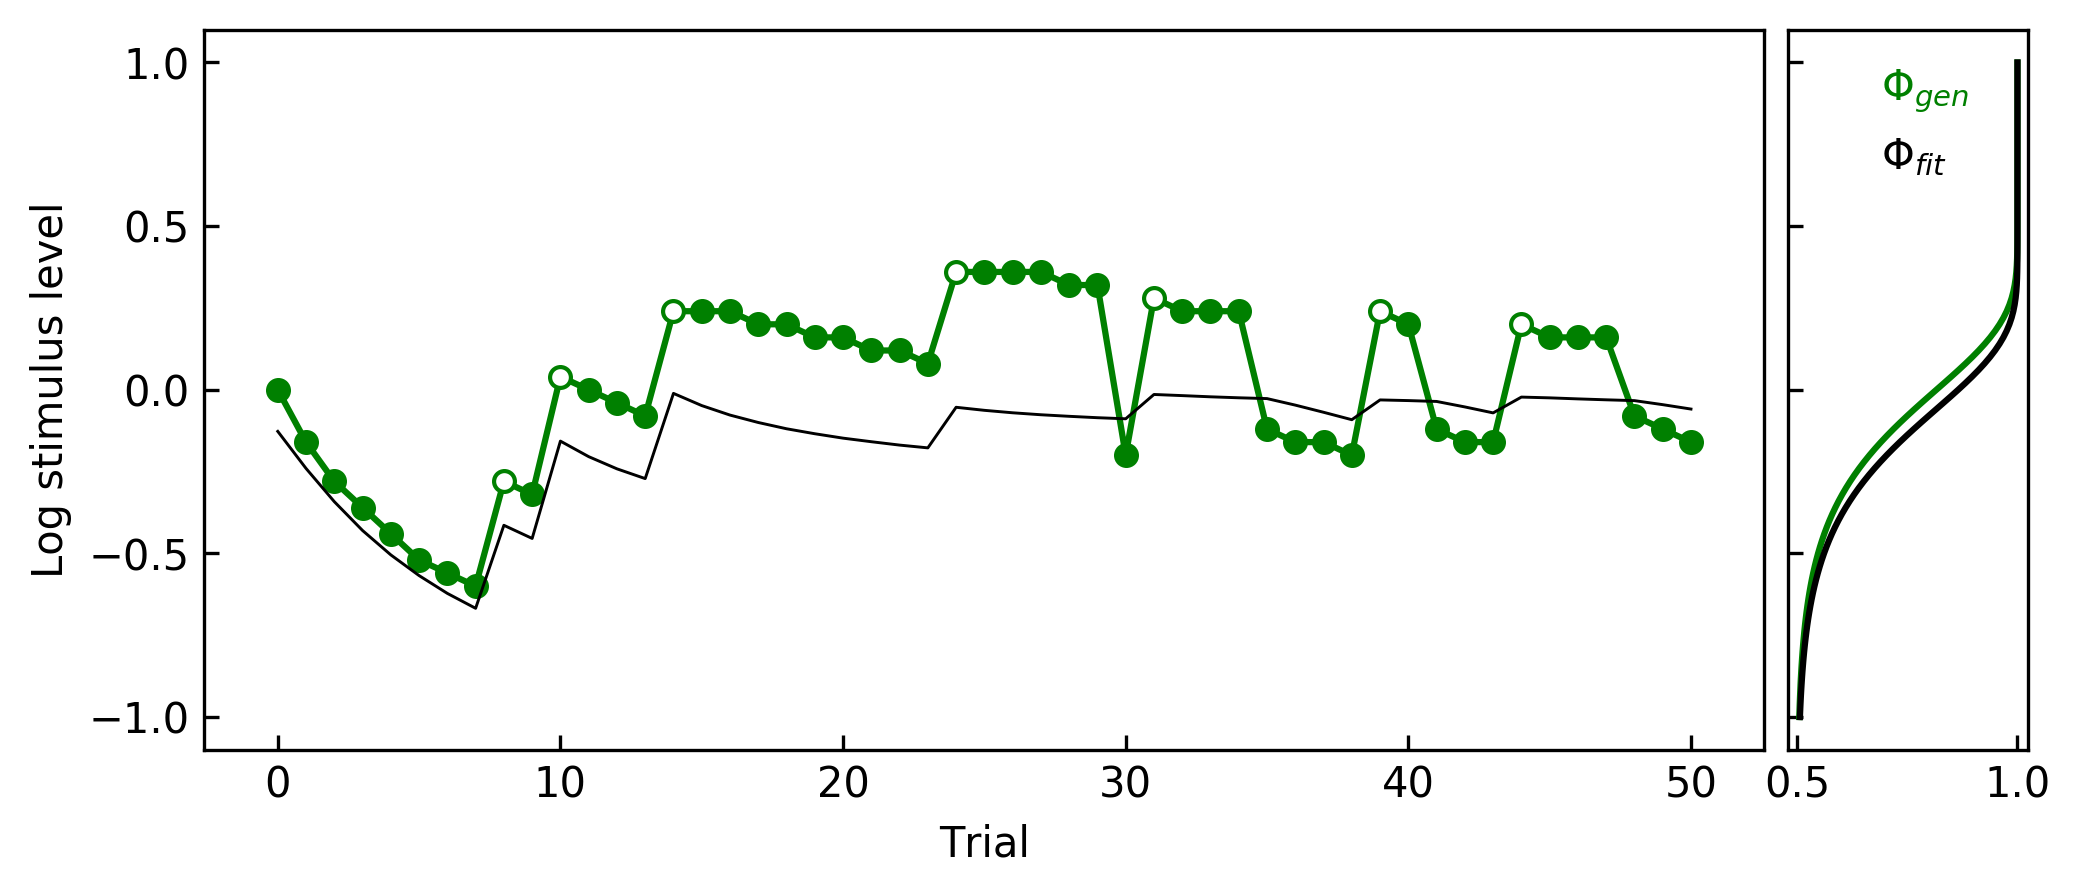

In [707]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.3
spacing = 0.01

rect = [left, bottom, width, height]
rect_y = [left + width + spacing, bottom, 0.1, height]

fig = plt.figure(figsize=(8, 8),dpi=300)

ax = fig.add_axes(rect)
ax_y = fig.add_axes(rect_y, sharey=ax)

ax.plot(PSI.x,c='g',zorder=1)
ax.plot(PSI.threshold,c='k',zorder=1,linewidth=0.7)

for ind,resp in enumerate(PSI.response):
    if resp == 0:
        ax.scatter(ind,PSI.x[ind],s=25,color='white', edgecolor='g',zorder=2)
    else:
        ax.scatter(ind,PSI.x[ind],s=25,color='g')
        
        
ax.set_xlabel('Trial')
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_ylabel('Log stimulus level')
ax.tick_params(axis="both",direction='in')

ax_y.plot(PF(PSI.priorAlphaRange,alpha_prior,10**beta_prior,0.5,0),PSI.priorAlphaRange,
         color='g',label='$\Phi_{gen}$')
ax_y.plot(PF(PSI.priorAlphaRange,PSI.threshold[-1],PSI.slope[-1],0.5,0),PSI.priorAlphaRange,
         color='k',label='$\Phi_{fit}$')

ax_y.tick_params(axis="both", labelleft=False,direction='in')
axy_legend = ax_y.legend(frameon=False,handlelength=0,loc='upper center')
axy_legend.texts[0].set_color('g')

plt.show()
fig.savefig('psi.jpg')
